# Глубокий кросс-энтропийный метод

#### Дедлайн (жёсткий) задания: 13 марта, 23:59 UTC+3

#### При сдаче задания нужно данный файл и сгенерированные в результате его работы файлы и директории поместить в архив, сохраняя относительные пути, и послать архив в систему сдачи

В данной работе будет рассмотрено обобщение кросс-энтропийного метода на случай параметризации агента с помощью нейросети. Перед вами будет поставлена задача обучить многослойную нейронную сеть для решения простых игр в непрерывных пространствах состояний.

# Автор: Богданов Александр Иванович, Б05-003.

In [1]:
import gymnasium as gym
import numpy as np
from pathlib import Path
import pickle as pkl
import pandas as pd
from time import time
from IPython.display import clear_output
from sklearn.neural_network import MLPClassifier, MLPRegressor
from collections import deque
from joblib import Parallel, delayed
from functools import partial
from gymnasium.wrappers import RecordVideo
from IPython.display import HTML
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.)
import warnings
warnings.filterwarnings("ignore")

Скрыть предупреждения: эстетическая опция, можно не выполнять ячейку ниже:

размерность вектора состояний dim = 4
n_actions = 2


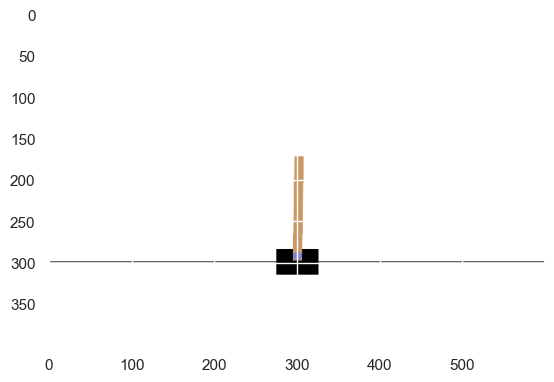

In [3]:
# если есть вывод "<classname> has no attribute .env", удалите .env или обновите gym
env = gym.make("CartPole-v1", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("размерность вектора состояний dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [4]:
env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

# Нейросетевая политика, основная задача (10 баллов)

Для текущей задачи будет использована упрощённая нейронная сеть, реализованная в библиотеке __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Что для решения задачи понадобится:

* `agent.partial_fit(states, actions)` - выполнение одного прохода (одной эпохи) по данным для настройки параметров. В ходе вызова данного метода происходит приближённая максимизация вероятности :actions: при условии :states:
* `agent.predict_proba(states)` - оценка вероятностей всех действий, матрица формы __[len(states), n_actions]__


In [7]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# инициализация агента на размерности пространства состояний и пространства действий
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [32]:
def generate_session(env, agent, t_max=1000, test=False):
    """
    Сыграть отдельный эпизод, используя нейросетевую параметризацию агента.
    Останов после :t_max: шагов среды.
    """
    states, actions = [], []
    total_reward = 0

    s, _ = env.reset()

    for t in range(t_max):
        
        # Используйте модель агента для оценки распределения на действия для текущего состояния :s:
        probs = agent.predict_proba([s]).reshape(n_actions)

        assert probs.shape == (n_actions,), "Нужно получить вектор вероятностей (функция np.reshape в помощь)"
        
        # Используйте текущую оценку политики для выбора действия
        if test:
            # на тестовом прогоне или на валидации используйте
            # детерминированную стратегию
            a = np.argmax(probs)
        else:
            # сэмплирование пропорционально политике $\pi(a|s)$,
            # не нужно выбирать детерминированно наиболее вероятное действие
            a = np.random.choice(np.arange(n_actions), p=probs)

        new_s, r, terminated, truncated, _ = env.step(a)

        # Запись статистики текущего эпизода
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    return states, actions, total_reward

In [11]:
dummy_states, dummy_actions, dummy_reward = generate_session(agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-0.01189895  0.04035788 -0.02445844 -0.01123747]
 [-0.01109179 -0.15440491 -0.02468319  0.27362928]
 [-0.01417989  0.04106037 -0.0192106  -0.02673545]
 [-0.01335868 -0.15378089 -0.01974531  0.25982496]
 [-0.0164343  -0.3486155  -0.01454881  0.5462151 ]]
actions: [0, 1, 0, 0, 1]
reward: 5.0


### Шаги кросс-энтропийного метода
Общая схема кросс-энтропийного метода (CEM) приведена на странице 35 (параграф 2.2.4.) учебного [пособия](https://arxiv.org/pdf/2201.09746.pdf).

Глубокий CEM использует точно такую же стратегию, что и обычный CEM.

Главное отличие состоит в том, что теперь каждое наблюдение не число, а `float32` вектор.

In [33]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Выбрать states и actions из игр с rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, оба 1D lists of states и actions из наилучших эпизодов

    Просьба сохранять порядок elite states и actions 
    [то есть сортированы по номерам эпизодов и в хронологическом порядке в каждом эпизоде]

    Просьба не считать по умолчанию states как целочисленные значения
    (они позже примут другой формат).
    """

    reward_threshold = np.percentile(rewards_batch, q=percentile)

    elite_states = []
    elite_actions = []
    
    for i, r in enumerate(rewards_batch):
        if r >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
        
    # Заметим, что это отличается от табличного случая.
    # Теперь наша нейронная сеть обучается на одном объекте с входной размерностью `(1, n_states)`.
    # То есть следует использовать `np.squeeze`, чтобы избавиться от ведущего измерения в `select_elites`.
    
    return elite_states, elite_actions

# Цикл обучения
Генерация эпизодов, выбор N лучших и обучение на них.

In [16]:
def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    Функция-помощник, которая визуализирует процесс обучения.
    Никакой крутой математики здесь нет, только построение графиков.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    print("средняя награда = %.3f, порог = %.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Средние награды')
    plt.plot(list(zip(*log))[1], label='Пороги наград')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="перцентиль", color='red')
    plt.legend()
    plt.grid()

    clear_output(True)
    plt.show()

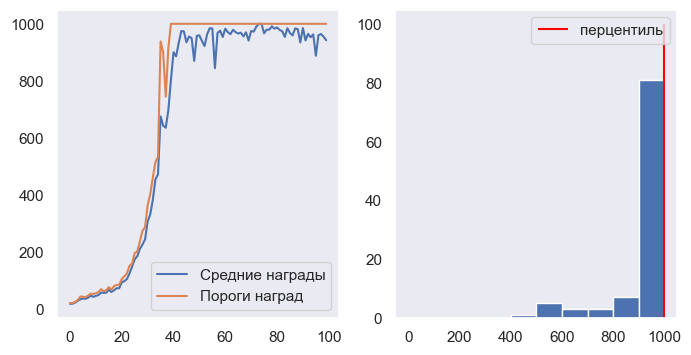

Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
CPU times: user 4min 52s, sys: 34.6 s, total: 5min 27s
Wall time: 4min 9s


In [16]:
%%time

n_sessions = 100
percentile = 70
log = []

for i in range(100):
    print("Итерация метода № {}:".format(i + 1))
    # генерация новых эпизодов
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.")

# Результаты

In [38]:
with RecordVideo(
    env=gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder="./videos/Cart_T",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent, test=True) for _ in range(100)]

Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-0.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-1.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-2.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-3.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-4.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-5.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-6.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-7.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-8.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-9.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-10.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-11.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-12.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-13.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-14.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-15.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-15.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-16.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-16.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-17.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-17.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-18.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-18.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-19.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-19.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-20.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-21.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-21.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-22.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-22.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-23.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-23.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-24.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-24.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-25.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-25.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-26.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-26.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-27.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-28.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-28.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-29.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-29.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-30.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-30.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-31.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-31.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-32.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-32.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-33.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-33.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-34.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-34.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-35.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-35.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-36.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-36.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-37.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-37.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-38.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-38.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-39.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-39.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-40.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-41.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-41.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-42.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-42.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-43.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-43.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-44.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-44.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-45.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-45.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-46.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-46.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-47.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-47.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-48.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-48.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-49.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-49.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-50.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-50.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-51.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-51.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-52.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-52.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-53.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-53.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-54.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-54.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-55.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-55.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-56.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-56.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-57.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-57.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-58.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-58.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-59.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-59.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-60.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-61.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-61.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-62.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-62.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-63.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-63.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-64.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-65.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-65.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-66.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-66.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-67.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-67.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-68.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-68.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-69.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-69.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-70.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-70.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-71.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-71.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-72.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-72.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-73.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-73.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-74.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-74.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-75.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-75.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-76.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-76.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-77.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-77.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-78.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-78.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-79.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-79.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-80.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-81.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-81.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-82.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-82.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-83.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-83.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-84.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-84.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-85.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-85.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-86.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-86.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-87.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-87.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-88.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-88.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-89.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-89.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-90.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-90.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-91.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-91.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-92.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-92.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-93.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-93.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-94.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-94.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-95.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-95.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-96.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-96.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-97.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-97.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-98.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-98.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-99.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_T/rl-video-episode-99.mp4


Детерминированная политика:

In [39]:
# демонстрация видео
video_paths = sorted([s for s in Path("videos", "Cart_T").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

In [40]:
with RecordVideo(
    env=gym.make("CartPole-v1", render_mode="rgb_array"),
    video_folder="./videos/Cart_F",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent, test=False) for _ in range(100)]

Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-0.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-1.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-2.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-3.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-4.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-5.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-6.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-7.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-8.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-9.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-10.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-11.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-12.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-13.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-14.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-15.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-15.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-16.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-16.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-17.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-17.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-18.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-18.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-19.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-19.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-20.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-21.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-21.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-22.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-22.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-23.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-23.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-24.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-24.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-25.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-25.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-26.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-26.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-27.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-28.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-28.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-29.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-29.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-30.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-30.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-31.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-31.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-32.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-32.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-33.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-33.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-34.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-34.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-35.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-35.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-36.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-36.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-37.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-37.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-38.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-38.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-39.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-39.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-40.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-41.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-41.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-42.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-42.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-43.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-43.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-44.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-44.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-45.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-45.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-46.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-46.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-47.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-47.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-48.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-48.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-49.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-49.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-50.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-50.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-51.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-51.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-52.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-52.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-53.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-53.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-54.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-54.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-55.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-55.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-56.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-56.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-57.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-57.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-58.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-58.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-59.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-59.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-60.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-61.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-61.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-62.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-62.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-63.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-63.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-64.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-65.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-65.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-66.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-66.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-67.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-67.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-68.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-68.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-69.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-69.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-70.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-70.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-71.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-71.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-72.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-72.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-73.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-73.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-74.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-74.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-75.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-75.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-76.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-76.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-77.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-77.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-78.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-78.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-79.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-79.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-80.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-81.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-81.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-82.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-82.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-83.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-83.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-84.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-84.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-85.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-85.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-86.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-86.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-87.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-87.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-88.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-88.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-89.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-89.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-90.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-90.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-91.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-91.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-92.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-92.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-93.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-93.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-94.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-94.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-95.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-95.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-96.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-96.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-97.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-97.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-98.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-98.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-99.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/test_F/rl-video-episode-99.mp4


Стохастическая политика:

In [41]:
# демонстрация видео
video_paths = sorted([s for s in Path("videos", "Cart_F").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

# Дополнительные задания

### Глубокий кросс-энтропийный метод

На данный момент у Вас должна быть достаточно хорошая награда в [CartPole-v1](https://www.gymlibrary.dev/environments/classic_control/cart_pole/), чтобы считать основное задание выполненным (см. ссылку). Время попробовать что-нибудь посложнее.

### Задания (вплоть до 5 баллов)

* __2.1__ Выбрать следующие среды: MountainCar-v0 и LunarLander-v2.
  * Для MountainCar, получить среднее вознаграждение __как минимум -150__
  * For LunarLander, получить среднее вознаграждение __как минимум +50__

Рекомендуем обратить внимание на раздел с советами ниже, это важно.

* __2.2__ Изучить зависимость скорости обучения агента от гипрепараметров алгоритма в среде MountainCar-v0. Постараться продемонстрировать возможность ускорения обучения хотя бы в два раза при грамотном подборе гиперпараметров
  * Очевидное улучшение: использовать [joblib](https://joblib.readthedocs.io/en/stable/) или multiprocessing
  * Попробовать переиспользовать сэмплы из 3-5 последних итераций при вычислении порога и при обучении
  * Поэкспериментировать с количеством итераций обучения и шагом метода обучения (learning rate) нейронной сети (смотреть params)

* __При сдаче задания требуется перечислить в данном файле, что было сделано и чего добились__
  
### Советы
* Страница Gym: [MountainCar](https://www.gymlibrary.dev/environments/classic_control/mountain_car/), [LunarLander](https://www.gymlibrary.dev/environments/box2d/lunar_lander/)
* Эпизоды в MountainCar могут длиться более 10k+ шагов. Убедитесь, что параметр ```t_max``` не меньше 10k.
 * Также может быть хорошей идеей строго отбирать награды через ">", а не ">=" (strictly_select_elites). Если 90% Ваших эпизодов имеют награду -10k и 20% лучше, тода если Вы используйте перцентиль 20% как порог, R >= порог __не может отклонить неуспешные эпизоды__, в то время как R > справляется с этим корректно.
* _проблема сред gym_: некоторые версии gym ограничивают эпизод 200 шагами. Это ограничивает возможности CEM в обучении в большинстве случаев. Убедитесь, что Ваш агент способен симулировать эпизоды с заданным __t_max__, и если нет, то попробуйте `env = gym.make("MountainCar-v0").env` или в ином случае избавьтесь от TimeLimit wrapper.
* Если Вы пользуетесь старой _swig_ библиотекой для LunarLander-v2, у Вас может возникнуть ошибка. Детали по [ссылке](https://github.com/openai/gym/issues/100) с решением проблемы.
* Если CEM не будет обучаться, то построение диаграмм распределения награды и запись видео эпизодов могут помочь: они Вас могут натолкнуть на идею исправления.
* 20-нейронной сети может не хватить, не стесняйтесь экспериментировать.

Ячейка с кодом ниже может оказаться полезной:

In [250]:
def visualize_mountain_car(env, agent):
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    grid = np.dstack(np.meshgrid(xs, vs)).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3)
    return probs

Функции-помощники для инициализации среды:

In [280]:
def get_env(name, classification=True):

    env = gym.make(name, render_mode="rgb_array").env
    
    env.reset()
    if classification:
        n_actions = env.action_space.n
    else:
        n_actions = sum(env.action_space.shape)
    state_dim = env.observation_space.shape[0]
    
    plt.imshow(env.render())
    print("state vector dim =", state_dim)
    print("n_actions =", n_actions)
    
    env.close()
    return env, n_actions, state_dim

Строгий отбор states и actions на основе перцентилей:

In [252]:
def strictly_select_elites(states_batch, actions_batch, rewards_batch, percentile=50, classification=True):
    """
    Выбрать states и actions из игр с rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, оба 1D lists of states и actions из наилучших эпизодов

    Просьба сохранять порядок elite states и actions 
    [то есть сортированы по номерам эпизодов и в хронологическом порядке в каждом эпизоде]

    Просьба не считать по умолчанию states как целочисленные значения
    (они позже примут другой формат).
    Отбор в случае решения задачи классификации и в случае решения задачи регрессии несколько отличаются.
    """

    reward_threshold = np.percentile(rewards_batch, q=percentile)

    elite_states = []
    elite_actions = []
    
    for i, r in enumerate(rewards_batch):
        if r >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    
    return elite_states, elite_actions

Обёртка для инициализации агента:

In [275]:
def init_agent(env, classification=True, **params):
    if classification:
        agent = MLPClassifier(
            hidden_layer_sizes=(20, 20, 20, 20),
            activation='tanh',
        )
    else:
        agent = MLPRegressor(
            hidden_layer_sizes=(20, 20, 20, 20),
            activation='tanh',
        )
    
    agent.set_params(**params)
    
    if classification:
        n_actions = env.action_space.n
        agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))
    else:
        n_actions = sum(env.action_space.shape)
        if n_actions > 1:
            agent.partial_fit([env.reset()[0]], np.random.randn(1, n_actions))
        else:
            agent.partial_fit([env.reset()[0]], np.random.randn(n_actions))
    
    return agent

Генератор эпизодов, приспособленный к параллелизации:

In [291]:
def generate_parallel_session(agent, name='MountainCar-v0', t_max=10000, classification=True,
                              epsilon=0.01, agent_mul_fac=1.0, test=False, env=None):
    """
    Сыграть отдельный эпизод, используя нейросетевую параметризацию агента.
    Останов после :t_max: шагов среды.
    """
    
    states, actions = [], []
    total_reward = 0
    
    if env is None:
        env = gym.make(name, render_mode="rgb_array").env
    if classification:
        n_actions = env.action_space.n
    else:
        n_actions = sum(env.action_space.shape)
    s, _ = env.reset()

    for t in range(t_max):
        
        if classification:
            probs = agent.predict_proba([s]).reshape(n_actions)

            assert probs.shape == (n_actions,), "Нужно получить вектор вероятностей" +\
                "(функция np.reshape в помощь)"
            
            if test:
                a = np.argmax(probs)
            else:
                a = np.random.choice(np.arange(n_actions), p=probs)
           
        else:
            expected_action = agent.predict([s]) * agent_mul_fac
            
            if test:
                a = expected_action[0]
            else:
                a = np.random.normal(expected_action, epsilon)[0]
                
        new_s, r, terminated, truncated, _ = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break
    
    del env, s, new_s, a
    
    return states, actions, total_reward

Функция для обучения агента:

In [273]:
def train_agent(agent = None, classification=True, epsilon=0.01, name='MountainCar-v0', n_train_steps=100,
                n_game_steps=10000, n_sessions=100, percentile=70, goal_score=-150, history_length=4,
                n_jobs=16, verbose=True, agent_mul_fac=1.0, **params):

    env = gym.make(name, render_mode="rgb_array").env
        
    if classification:
        n_actions = env.action_space.n
    else:
        n_actions = sum(env.action_space.shape)
    
    if agent is None:
        agent = init_agent(env, classification, **params)
    
    if verbose:
        print('Шаг агента = {}'.format(agent.learning_rate_init), flush=True)
    
    log = []
    sessions = deque([], history_length * n_sessions)
    
    for i in range(n_train_steps):
        if n_jobs > 1:
            sessions.extend(Parallel(n_jobs=n_jobs)(delayed(partial(generate_parallel_session, agent, name,
                                                                    n_game_steps, classification,
                                                                    epsilon, agent_mul_fac))(x)\
                                                    for x in [False] * n_sessions))
        else:
            sessions.extend([generate_parallel_session(
                agent, name, n_game_steps, classification, epsilon, agent_mul_fac, 
                False) for _ in range(n_sessions)])
        
        states_batch, actions_batch, rewards_batch = zip(*sessions)
        elite_states, elite_actions = strictly_select_elites(
            states_batch, actions_batch, rewards_batch, percentile, classification)
        
        if classification:
            agent.partial_fit(elite_states, elite_actions)
        else:
            elite_actions = np.array(elite_actions)
            elite_actions = elite_actions if (len(elite_actions.shape) < 2) or (elite_actions.shape[1] > 1)\
                            else elite_actions.reshape(-1)
            agent.partial_fit(elite_states, elite_actions / agent_mul_fac)
        
        if verbose:
            inter_min = np.min(rewards_batch)
            min_lim = -n_game_steps if -n_game_steps < inter_min else inter_min
            inter_max = np.max(rewards_batch)
            max_lim = goal_score if goal_score > inter_max else inter_max
            show_progress(rewards_batch, log, percentile, reward_range=[min_lim, max_lim])
            
            if np.mean(rewards_batch) > goal_score:
                mean_reward = np.mean(rewards_batch)
                threshold = np.percentile(rewards_batch, percentile)
                print("средняя награда = %.3f, порог=%.3f" % (mean_reward, threshold))
                print("Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.")
                return agent, log
    
        if verbose:
            mean_reward = np.mean(rewards_batch)
            threshold = np.percentile(rewards_batch, percentile)
            print("средняя награда = %.3f, порог=%.3f" % (mean_reward, threshold))
            del mean_reward, threshold
        
        del states_batch, actions_batch, rewards_batch, elite_states, elite_actions
    
    del env, sessions
    
    return agent, log

Функция для постановки экспериментов, зависящих от набора гиперпараметров:

In [256]:
def training_experiment(n_jobs_list, history_length_list, learning_rate_init_list, n_train_steps_list,
                        n_samples=5, name='MountainCar-v0', n_game_steps=10000, n_sessions=100, percentile=70,
                        goal_score=-150, **params):
    experiment_data = []
    
    for n_jobs in n_jobs_list:
        for history_length in history_length_list:
            for learning_rate_init in learning_rate_init_list:
                params['learning_rate_init'] = learning_rate_init
                for n_train_steps in n_train_steps_list:
                    elapsed_time_list = []
                    log_list = []
                    
                    for i in range(n_samples):
                        print(
                            'Запуск: n_jobs = {}, history_length = {},\n'.format(
                                n_jobs, history_length) +\
                            '                  learning_rate_init = {}, n_train_steps = {};\n'.format(
                                learning_rate_init, n_train_steps) +\
                            'сэмпл {} из {}.'.format(
                                i + 1, n_samples), flush=True)
                        
                        elapsed_time = time()
                        
                        agent, log = train_agent(
                            classification=True, epsilon=0.01, name=name, n_train_steps=n_train_steps,
                            n_game_steps=n_game_steps, n_sessions=n_sessions, percentile=percentile,
                            goal_score=goal_score, history_length=history_length, n_jobs=n_jobs, verbose=True,
                            **params)
                        
                        elapsed_time_list.append(time() - elapsed_time)
                        
                        log_list.append(log)
                        
                        del log, agent
                        
                    results = {
                               'name': name,
                               'goal_score': goal_score,
                               'n_jobs': n_jobs,
                               'elapsed_time_list': elapsed_time_list,
                               'history_length': history_length,
                               'learning_rate_init': learning_rate_init,
                               'n_train_steps': n_train_steps,
                               'log_list': log_list
                              }
                        
                    experiment_data.append(results)
                    
                    del elapsed_time_list, log_list
    return experiment_data

Функция-помощник для визуализации эффектов от переиспользования сэмплов:

In [257]:
def plot_history_length_experiment_results(df_data):
    history_length_vals = []
    train_step_vals = []
    reward_vals = []
    mean_threshold_vals = []
    
    for config in df_data:
        for log in config['log_list']:
            mean_rewards, reward_thresholds = zip(*log)
            mean_rewards, reward_thresholds = list(mean_rewards), list(reward_thresholds)
            reward_vals.extend(mean_rewards)
            reward_vals.extend(reward_thresholds)
            train_steps_num = len(mean_rewards)
            train_step_vals.extend(range(train_steps_num))
            train_step_vals.extend(range(train_steps_num))
            history_length_vals.extend([config['history_length']] * train_steps_num * 2)
            mean_threshold_vals.extend(['mean'] * train_steps_num)
            mean_threshold_vals.extend(['threshold'] * train_steps_num)
    
    df = pd.DataFrame({'Переиспользованных шагов': history_length_vals, 'Шаг №': train_step_vals,
                       'Награда': reward_vals, 'Вид награды': mean_threshold_vals})
    last_steps_count = np.sort(df.loc[:, 'Переиспользованных шагов'].unique())
    max_n_colors = last_steps_count.size
    palette = dict(zip(last_steps_count, sns.hls_palette(max_n_colors, l=.45, s=.8)))
    
    sns.set(font_scale=1.35)
    g = sns.relplot(x='Шаг №', y='Награда', hue='Переиспользованных шагов', style='Вид награды', kind='line',
                    data=df, height=8, aspect=1.5, palette=palette)
    g.fig.suptitle('Влияние количества переиспользованных шагов при обучении {}'.format(df_data[0]['name']))
    clear_output(True)
    plt.show()

Функция-помощник для визуализации влияния шага обучения и количества итераций при обучении агента:

In [258]:
def plot_lrt_experiment_results(df_data):
    learning_rate_vals = []
    max_train_steps_vals = []
    train_step_vals = []
    reward_vals = []
    mean_threshold_vals = []
    
    for config in df_data:
        for log in config['log_list']:
            mean_rewards, reward_thresholds = zip(*log)
            mean_rewards, reward_thresholds = list(mean_rewards), list(reward_thresholds)
            reward_vals.extend(mean_rewards)
            reward_vals.extend(reward_thresholds)
            train_steps_num = len(mean_rewards)
            train_step_vals.extend(range(train_steps_num))
            train_step_vals.extend(range(train_steps_num))
            learning_rate_vals.extend([config['learning_rate_init']] * train_steps_num * 2)
            max_train_steps_vals.extend([config['n_train_steps']] * train_steps_num * 2)
            mean_threshold_vals.extend(['mean'] * train_steps_num)
            mean_threshold_vals.extend(['threshold'] * train_steps_num)
       
    df = pd.DataFrame({'Шаг метода': learning_rate_vals, 'Максимум шагов': max_train_steps_vals,
                       'Шаг №': train_step_vals, 'Награда': reward_vals,
                       'Вид награды': mean_threshold_vals})
    
    lr_vals = np.sort(df.loc[:, 'Шаг метода'].unique())
    max_n_colors = lr_vals.size
    palette = dict(zip(lr_vals, sns.hls_palette(max_n_colors, l=.45, s=.8)))
    
    sns.set(font_scale=1.35)
    g = sns.relplot(x='Шаг №', y='Награда', hue='Шаг метода', style='Вид награды', kind='line',
                    row='Максимум шагов', data=df, height=6, aspect=1.8, palette=palette)
    g.fig.suptitle('Влияние шага метода и количества итераций на {}'.format(df_data[0]['name']),
                   x=0.8, y=1.05)
    leg = g._legend
    for lr, label in zip(lr_vals, leg.texts[1:]):
        label.set_text("{:.4f}".format(lr))
    clear_output(True)
    plt.show()

Функция для записи сэмплированных игровых эпизодов:

In [259]:
def record_sessions(agent, name, en="MountainCar-v0", t_max=10000, classification=True, epsilon=0.01, agent_mul_fac=1.0, test=True):
    with RecordVideo(
        env=gym.make(en, render_mode="rgb_array"),
        video_folder="./videos/{}".format(name),
        episode_trigger=lambda episode_number: True,
    ) as env_monitor:
        sessions = [generate_parallel_session(agent, name=name, t_max=t_max, classification=classification,
                                              epsilon=epsilon, agent_mul_fac=agent_mul_fac, test=test,
                                              env=env_monitor) for _ in range(100)]

Функция, позволяющая вставить запись игрового эпизода в ноутбук:

In [36]:
def show_video(name):
    video_paths = sorted([s for s in Path("videos", name).iterdir() if s.suffix == ".mp4"])
    video_path = video_paths[-1]
    data_url = str(video_path)
    print(data_url)
    HTML(
        """
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format(
            data_url
        )
    )

Сетка параметров для проведения экспериментов:

In [135]:
n_jobs_list = range(12, 16)
history_length_list = range(3, 6, 10)
learning_rate_init_list = np.logspace(-3, -4, 1)
n_train_steps_list = range(10, 11, 10)

## Глубокий кросс-энтропийный метод в среде MountainCar-v0

state vector dim = 2
n_actions = 3


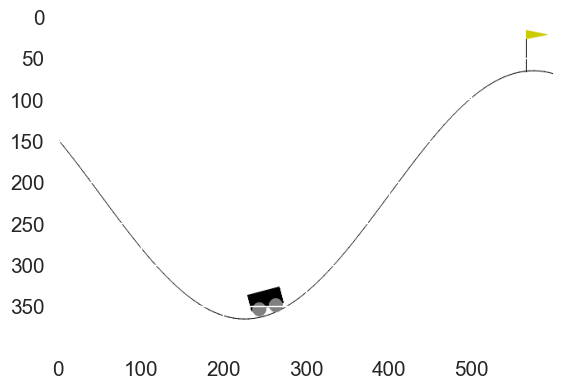

In [27]:
env, n_actions, _ = get_env("MountainCar-v0")

In [137]:
env.observation_space, env.action_space

(Box([-1.2  -0.07], [0.6  0.07], (2,), float32), Discrete(3))

Поиск оптимального количества параллельных легковесных процессов (нитей) на конечной машине:

In [138]:
%%time

n_jobs_experiment_data = training_experiment(n_jobs_list, history_length_list, learning_rate_init_list, n_train_steps_list)

pkl.dump(n_jobs_experiment_data, open('MountainCar-v0_n_jobs_experiment_data.pkl', 'wb'))
clear_output(True)

CPU times: user 15min 21s, sys: 3min 35s, total: 18min 57s
Wall time: 26min 41s


Визуализация результатов эксперимента:

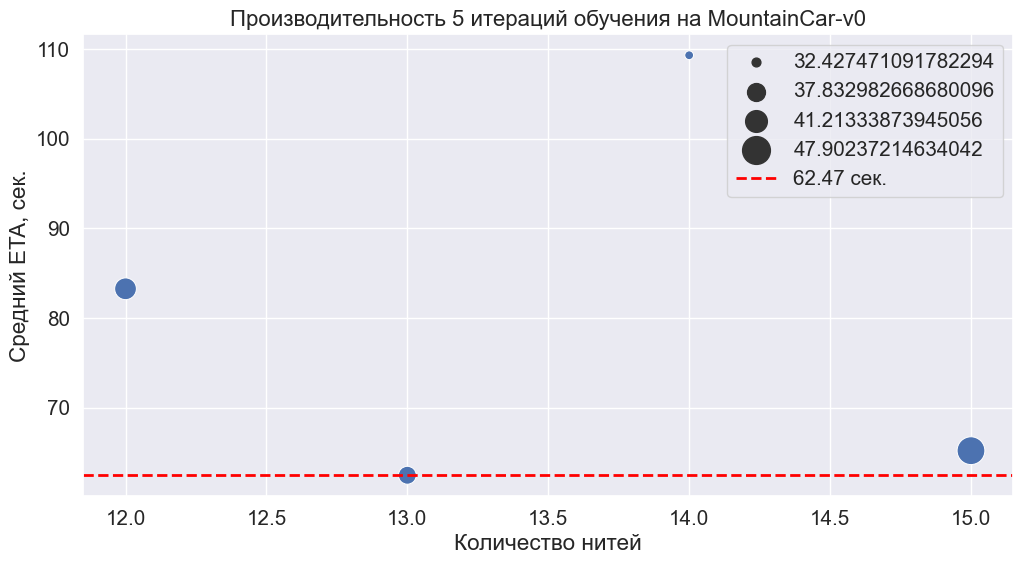

In [139]:
n_jobs_vals = []
elapsed_time_vals = []
elapsed_time_vars = []

for config in n_jobs_experiment_data:
    n_jobs_vals.append(config['n_jobs'])
    elapsed_time_vals.append(np.mean(config['elapsed_time_list']))
    elapsed_time_vars.append(np.std(config['elapsed_time_list']))

df = pd.DataFrame({'Количество нитей': n_jobs_vals, 'Средний ETA, сек.': elapsed_time_vals,
                   'Стандартное отклонение ETA': elapsed_time_vars})

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.35)
plt.title('Производительность 5 итераций обучения на {}'.format(n_jobs_experiment_data[0]['name']),
          fontsize=16)
ax = sns.scatterplot(x='Количество нитей', y='Средний ETA, сек.', size='Стандартное отклонение ETA',
                     sizes=(40, 400), data=df)
min_val = np.min(elapsed_time_vals)
ax.axhline(min_val, color='red', ls='--', linewidth=2, label='{:.2f} сек.'.format(min_val))
plt.legend()
clear_output(True)
plt.show()

Оптимальней всего использовать 13 нитей.

Исследование влияния переиспользования сэмплов в процессе обучения:

In [140]:
n_jobs_list = range(13, 14)
history_length_list = range(3, 6, 1)
learning_rate_init_list = np.logspace(-3, -4, 1)
n_train_steps_list = range(10, 11, 10)

In [141]:
%%time

history_length_experiment_data = training_experiment(n_jobs_list, history_length_list, learning_rate_init_list, n_train_steps_list)

pkl.dump(history_length_experiment_data, open('MountainCar-v0_history_length_experiment_data.pkl', 'wb'))
clear_output(True)

CPU times: user 15min 47s, sys: 3min 15s, total: 19min 3s
Wall time: 25min 53s


Результаты текущего эксперимента:

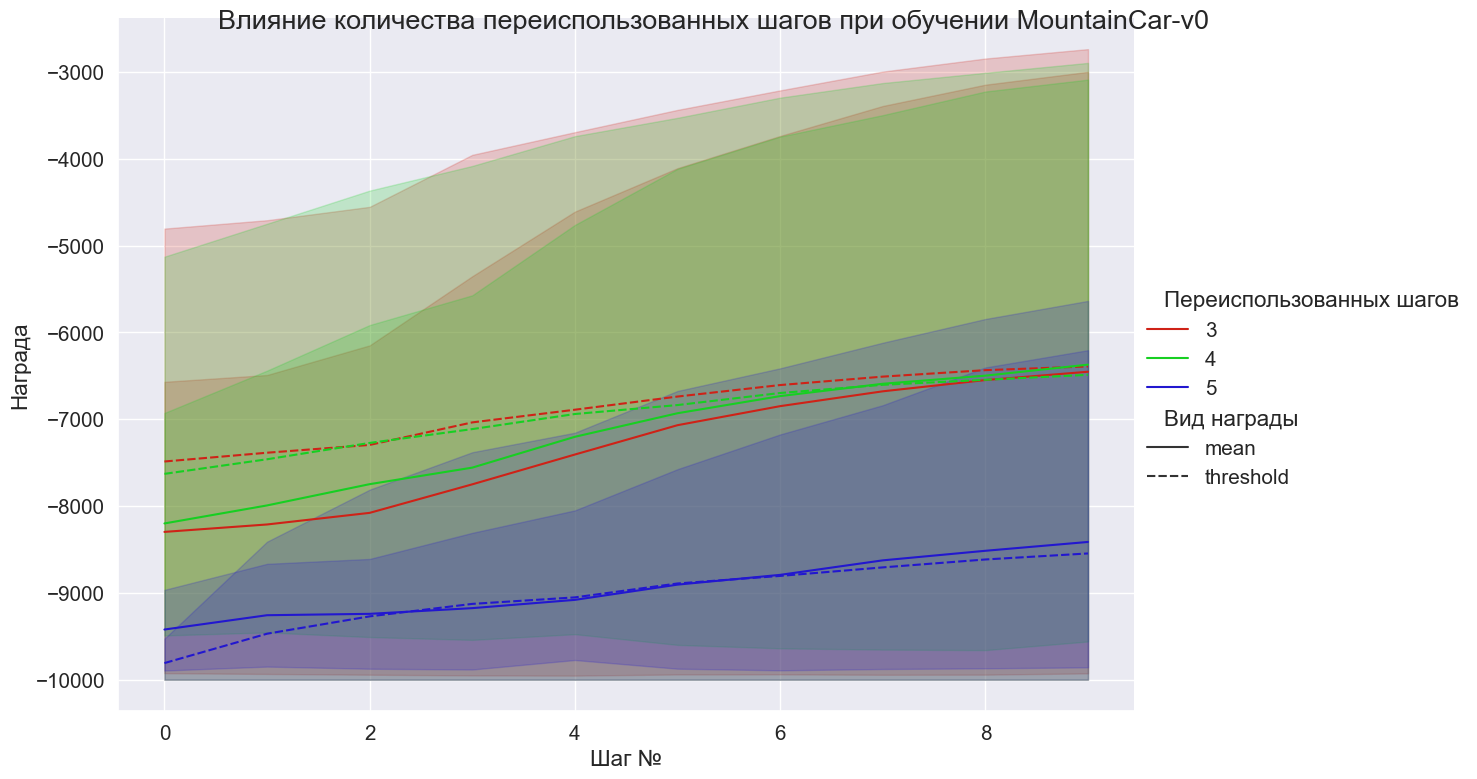

In [142]:
plot_history_length_experiment_results(history_length_experiment_data)

Как мы видим, лучше всего использовать 4.

Поиск оптимального шага обучения для многослойного перцептрона (MLP) вместе c подбором количества шагов обучения:

In [163]:
n_jobs_list = range(13, 14)
history_length_list = range(4, 5, 1)
learning_rate_init_list = np.logspace(-4, -1, 4)
n_train_steps_list = range(10, 11, 10)

In [164]:
%%time

lrt_experiment_data = training_experiment(n_jobs_list, history_length_list, learning_rate_init_list, n_train_steps_list)

pkl.dump(lrt_experiment_data, open('MountainCar-v0_lrt_experiment_data.pkl', 'wb'))
clear_output(True)

CPU times: user 22min 5s, sys: 2min 18s, total: 24min 24s
Wall time: 34min 22s


Результаты текущего эксперимента:

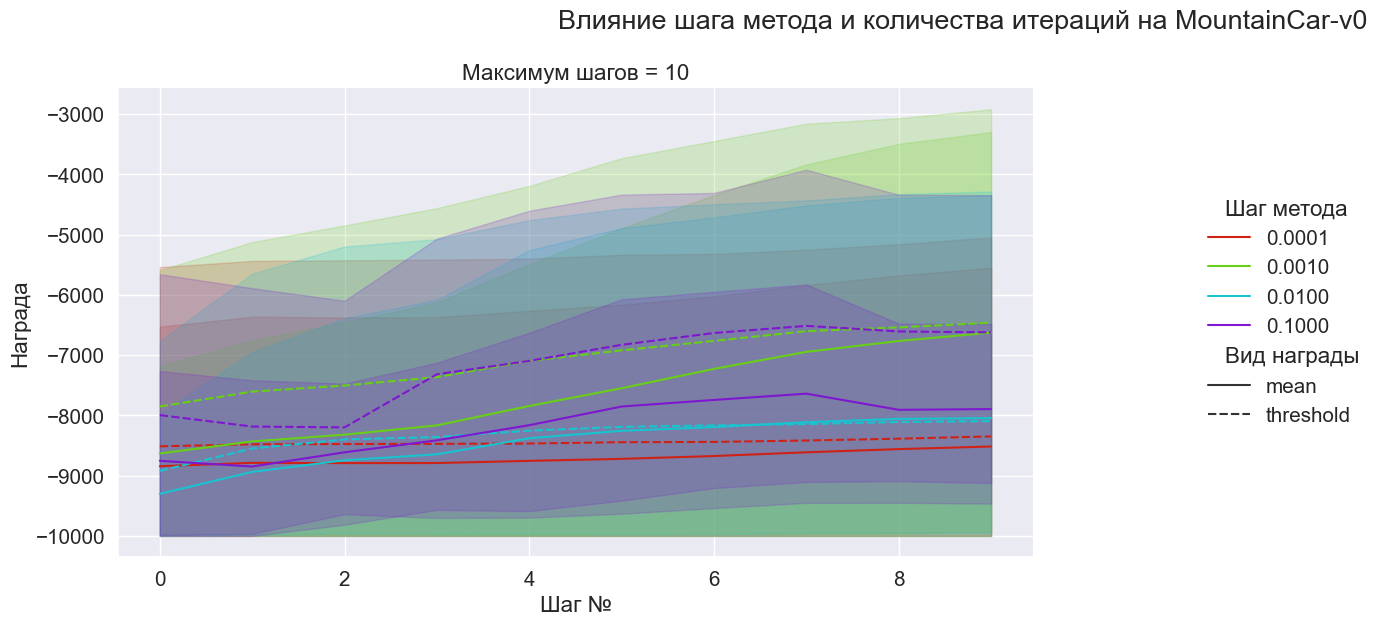

In [180]:
plot_lrt_experiment_results(lrt_experiment_data)

Как мы видим, лучше всего использовать шаг метода 0,001.

In [19]:
n_jobs_list = range(13, 14)
history_length_list = range(4, 5, 1)
learning_rate_init_list = np.logspace(-3, -3, 1)
n_train_steps_list = range(70, 121, 10)

In [20]:
%%time

steps_experiment_data = training_experiment(n_jobs_list, history_length_list, learning_rate_init_list, n_train_steps_list, n_samples=1)

pkl.dump(steps_experiment_data, open('MountainCar-v0_steps_experiment_data.pkl', 'wb'))
clear_output(True)

CPU times: user 1h 8min 42s, sys: 7min 24s, total: 1h 16min 6s
Wall time: 2h 33min 36s


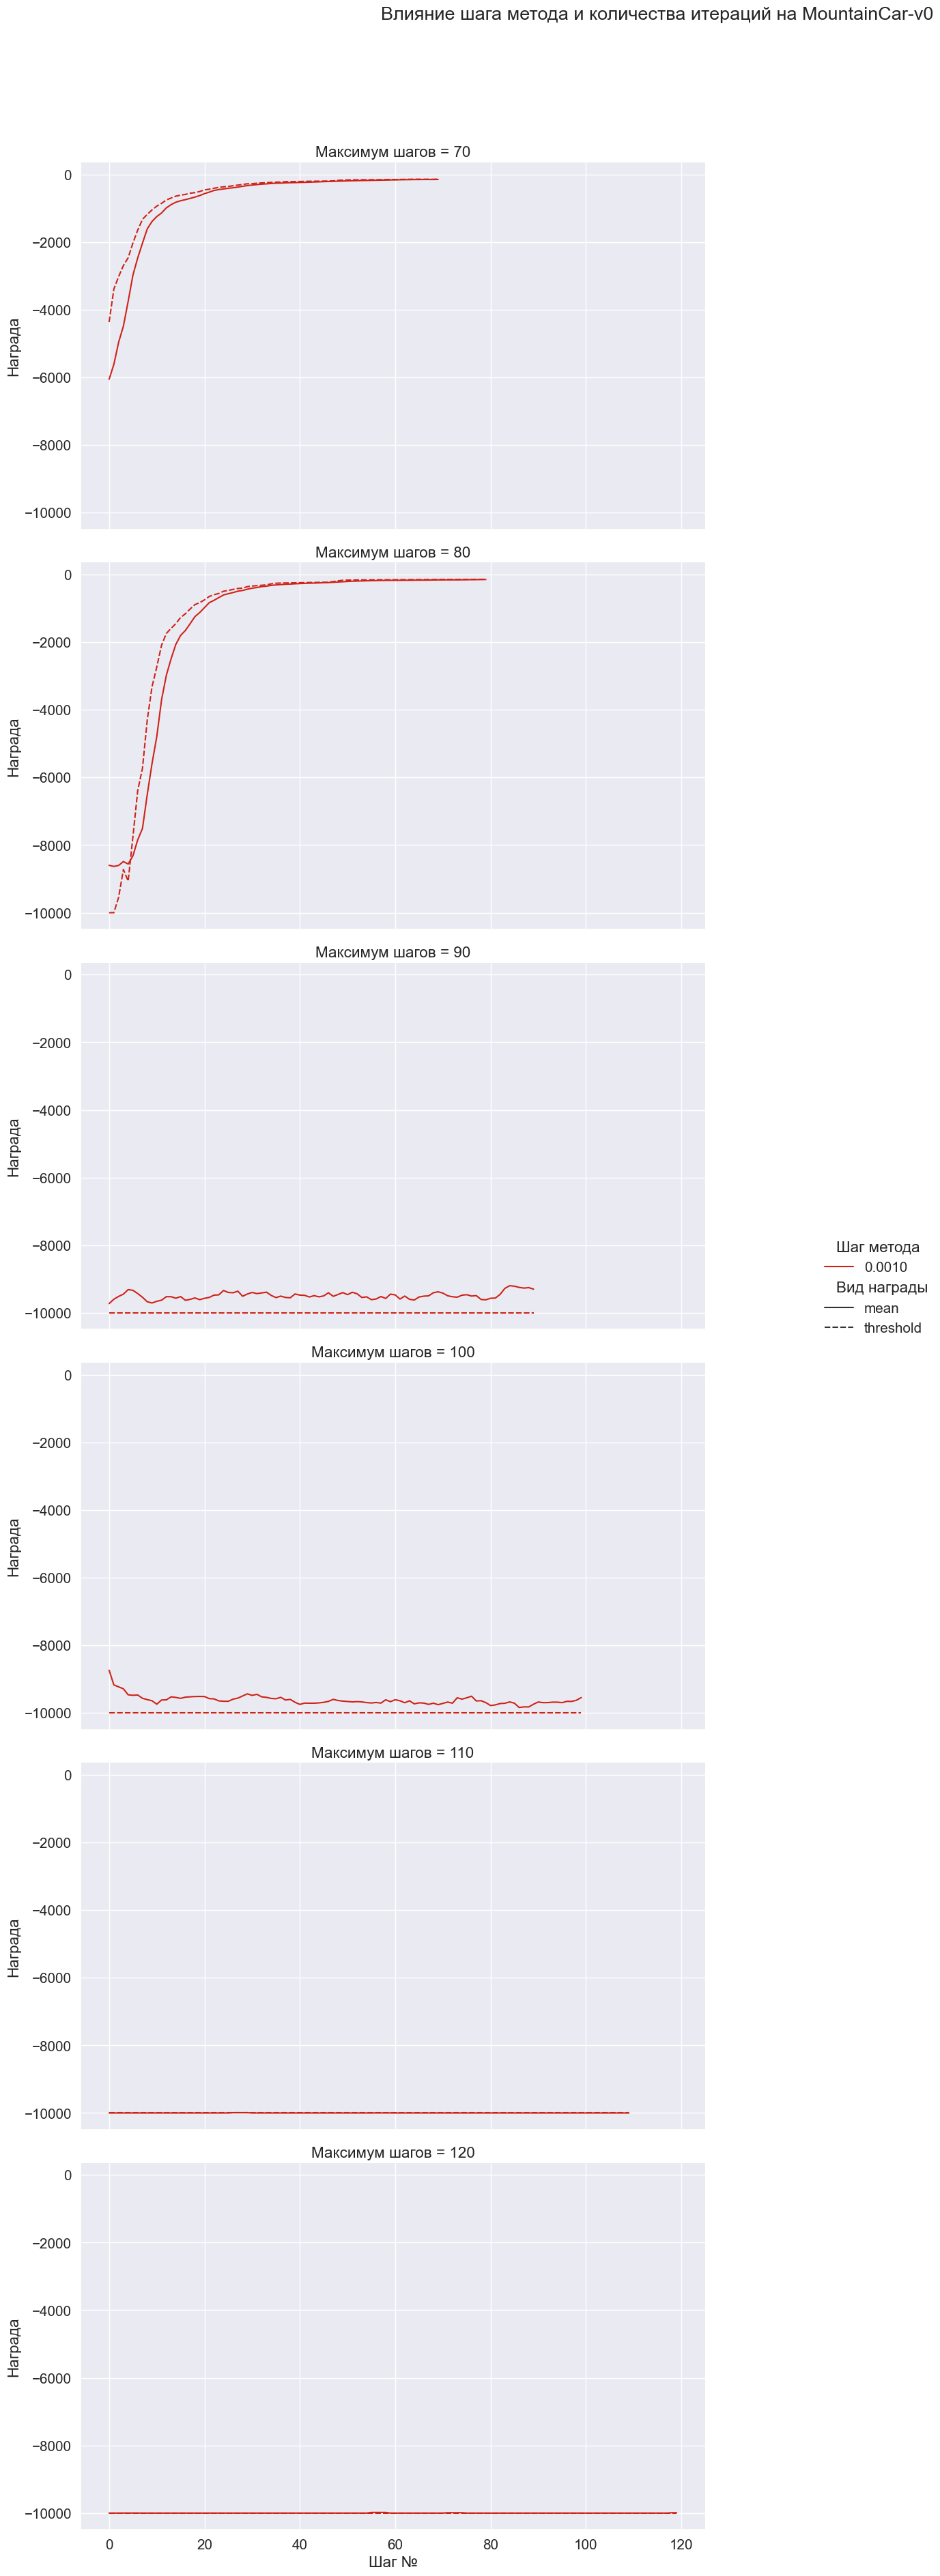

In [21]:
plot_lrt_experiment_results(steps_experiment_data)

Обучение агента на задаче MountainCar-v0 с использованием подобранных ранее гиперпараметров:

Лучше всего использовать 80 шагов.

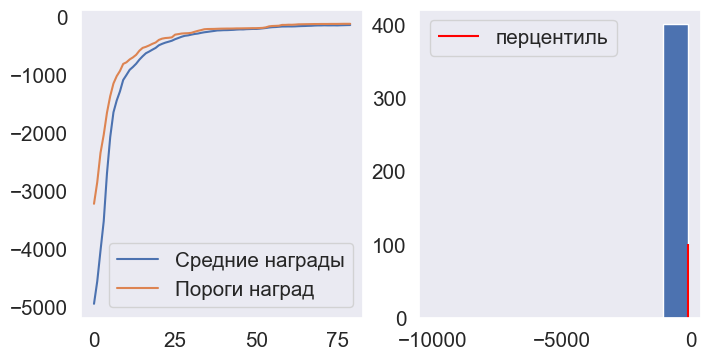

Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
средняя награда = -140.012, порог=-119.000
CPU times: user 1min 14s, sys: 3.46 s, total: 1min 17s
Wall time: 49.1 s


In [25]:
%%time

params = {}
params['learning_rate_init'] = 0.001
agent, _  = train_agent(classification=True, epsilon=0.01, name='MountainCar-v0', n_train_steps=80,
                n_game_steps=10000, n_sessions=100, percentile=70, goal_score=-150, history_length=4,
                n_jobs=15, verbose=True, agent_mul_fac=1.0, **params)

Визуализация действий обученного агента в зависимости скорости и положения:

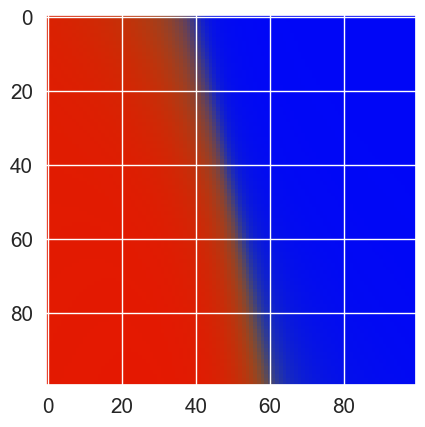

In [28]:
plt.imshow(visualize_mountain_car(env, agent))

Сэмпл детерминированной стратегии по въезду на холм:

In [30]:
record_sessions(agent, "Car_T", test=True)

Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-0.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-1.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-2.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-3.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-4.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-5.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-6.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-7.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-8.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-9.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-10.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-11.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-12.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-13.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-14.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-15.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-15.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-16.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-16.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-17.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-17.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-18.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-18.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-19.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-19.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-20.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-21.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-21.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-22.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-22.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-23.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-23.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-24.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-24.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-25.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-25.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-26.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-26.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-27.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-28.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-28.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-29.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-29.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-30.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-30.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-31.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-31.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-32.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-32.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-33.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-33.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-34.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-34.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-35.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-35.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-36.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-36.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-37.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-37.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-38.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-38.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-39.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-39.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-40.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-41.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-41.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-42.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-42.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-43.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-43.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-44.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-44.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-45.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-45.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-46.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-46.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-47.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-47.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-48.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-48.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-49.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-49.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-50.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-50.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-51.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-51.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-52.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-52.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-53.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-53.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-54.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-54.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-55.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-55.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-56.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-56.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-57.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-57.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-58.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-58.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-59.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-59.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-60.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-61.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-61.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-62.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-62.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-63.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-63.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-64.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-65.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-65.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-66.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-66.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-67.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-67.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-68.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-68.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-69.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-69.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-70.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-70.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-71.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-71.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-72.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-72.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-73.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-73.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-74.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-74.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-75.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-75.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-76.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-76.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-77.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-77.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-78.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-78.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-79.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-79.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-80.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-81.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-81.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-82.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-82.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-83.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-83.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-84.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-84.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-85.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-85.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-86.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-86.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-87.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-87.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-88.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-88.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-89.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-89.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-90.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-90.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-91.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-91.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-92.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-92.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-93.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-93.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-94.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-94.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-95.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-95.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-96.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-96.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-97.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-97.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-98.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-98.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-99.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_T/rl-video-episode-99.mp4


In [39]:
video_paths = sorted([s for s in Path("videos", "Car_T").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)
HTML("""
    <video width="640" height="480" controls>
    <source src="{}" type="video/mp4">
    </video>
    """.format(data_url)
    )

Сэмпл стохастической стратегии по въезду на холм:

In [40]:
record_sessions(agent, "Car_F", test=False)

Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-0.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-1.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-2.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-3.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-4.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-5.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-6.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-7.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-8.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-9.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-10.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-11.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-12.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-13.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-14.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-15.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-15.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-16.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-16.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-17.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-17.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-18.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-18.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-19.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-19.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-20.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-21.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-21.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-22.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-22.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-23.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-23.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-24.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-24.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-25.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-25.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-26.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-26.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-27.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-28.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-28.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-29.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-29.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-30.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-30.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-31.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-31.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-32.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-32.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-33.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-33.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-34.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-34.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-35.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-35.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-36.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-36.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-37.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-37.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-38.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-38.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-39.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-39.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-40.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-41.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-41.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-42.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-42.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-43.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-43.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-44.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-44.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-45.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-45.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-46.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-46.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-47.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-47.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-48.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-48.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-49.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-49.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-50.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-50.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-51.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-51.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-52.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-52.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-53.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-53.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-54.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-54.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-55.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-55.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-56.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-56.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-57.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-57.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-58.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-58.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-59.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-59.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-60.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-61.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-61.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-62.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-62.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-63.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-63.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-64.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-65.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-65.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-66.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-66.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-67.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-67.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-68.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-68.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-69.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-69.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-70.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-70.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-71.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-71.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-72.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-72.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-73.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-73.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-74.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-74.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-75.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-75.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-76.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-76.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-77.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-77.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-78.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-78.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-79.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-79.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-80.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-81.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-81.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-82.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-82.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-83.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-83.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-84.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-84.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-85.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-85.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-86.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-86.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-87.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-87.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-88.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-88.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-89.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-89.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-90.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-90.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-91.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-91.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-92.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-92.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-93.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-93.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-94.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-94.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-95.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-95.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-96.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-96.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-97.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-97.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-98.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-98.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-99.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Car_F/rl-video-episode-99.mp4


In [41]:
video_paths = sorted([s for s in Path("videos", "Car_F").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)
HTML("""
    <video width="640" height="480" controls>
    <source src="{}" type="video/mp4">
    </video>
    """.format(data_url)
    )

## Обучение агента в среде LunarLander-v2

state vector dim = 8
n_actions = 4


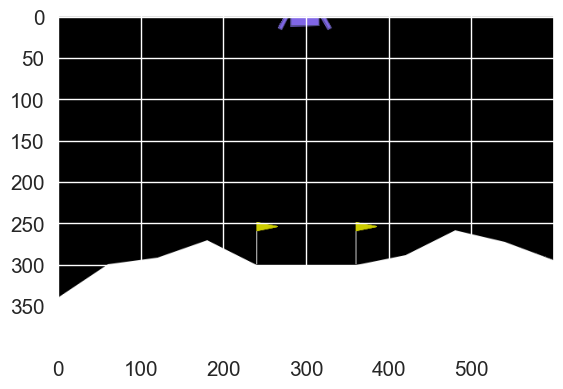

In [55]:
env, n_actions, _ = get_env("LunarLander-v2")

In [56]:
env.observation_space, env.action_space

(Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
  -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
  1.       ], (8,), float32),
 Discrete(4))

Обучение агента:

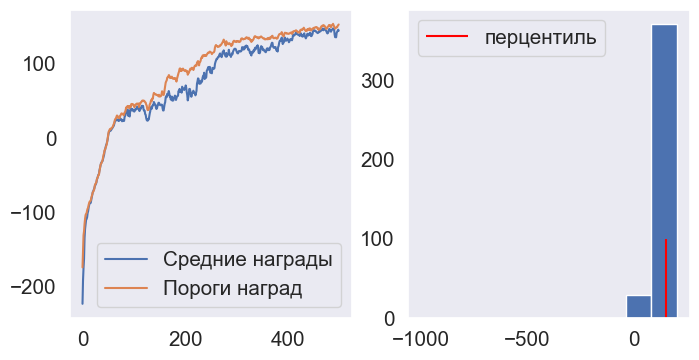

Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
средняя награда = 144.518, порог=152.878
CPU times: user 11min 24s, sys: 24.1 s, total: 11min 48s
Wall time: 1h 6min 34s


In [91]:
%%time

params = {}
params['learning_rate_init'] = 0.001
agent, _  = train_agent(classification=True, epsilon=0.01, name='LunarLander-v2', n_train_steps=500,
                n_game_steps=1000, n_sessions=100, percentile=50, goal_score=50, history_length=4,
                n_jobs=16, verbose=True, agent_mul_fac=1.0, **params)

Детерминированная стратегия:

In [92]:
record_sessions(agent, "Lunar_T", en='LunarLander-v2', test=True)

Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-0.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-1.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-2.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-3.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-4.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-5.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-6.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-7.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-8.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-9.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-10.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-11.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-12.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-13.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-14.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-15.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-15.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-16.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-16.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-17.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-17.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-18.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-18.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-19.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-19.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-20.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-21.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-21.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-22.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-22.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-23.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-23.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-24.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-24.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-25.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-25.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-26.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-26.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-27.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-28.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-28.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-29.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-29.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-30.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-30.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-31.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-31.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-32.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-32.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-33.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-33.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-34.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-34.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-35.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-35.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-36.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-36.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-37.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-37.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-38.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-38.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-39.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-39.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-40.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-41.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-41.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-42.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-42.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-43.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-43.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-44.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-44.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-45.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-45.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-46.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-46.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-47.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-47.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-48.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-48.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-49.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-49.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-50.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-50.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-51.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-51.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-52.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-52.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-53.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-53.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-54.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-54.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-55.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-55.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-56.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-56.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-57.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-57.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-58.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-58.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-59.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-59.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-60.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-61.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-61.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-62.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-62.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-63.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-63.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-64.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-65.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-65.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-66.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-66.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-67.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-67.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-68.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-68.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-69.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-69.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-70.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-70.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-71.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-71.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-72.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-72.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-73.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-73.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-74.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-74.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-75.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-75.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-76.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-76.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-77.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-77.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-78.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-78.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-79.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-79.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-80.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-81.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-81.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-82.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-82.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-83.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-83.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-84.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-84.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-85.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-85.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-86.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-86.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-87.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-87.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-88.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-88.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-89.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-89.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-90.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-90.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-91.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-91.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-92.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-92.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-93.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-93.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-94.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-94.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-95.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-95.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-96.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-96.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-97.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-97.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-98.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-98.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-99.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_T/rl-video-episode-99.mp4


In [93]:
video_paths = sorted([s for s in Path("videos", "Lunar_T").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)
HTML("""
    <video width="640" height="480" controls>
    <source src="{}" type="video/mp4">
    </video>
    """.format(data_url)
    )

Стохастическая стратегия:

In [94]:
record_sessions(agent, "Lunar_F", en='LunarLander-v2', test=False)

Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-0.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-1.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-2.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-3.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-4.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-5.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-6.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-7.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-8.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-9.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-10.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-11.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-12.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-13.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-14.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-15.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-15.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-16.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-16.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-17.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-17.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-18.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-18.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-19.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-19.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-20.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-21.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-21.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-22.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-22.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-23.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-23.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-24.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-24.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-25.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-25.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-26.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-26.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-27.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-28.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-28.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-29.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-29.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-30.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-30.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-31.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-31.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-32.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-32.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-33.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-33.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-34.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-34.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-35.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-35.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-36.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-36.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-37.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-37.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-38.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-38.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-39.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-39.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-40.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-41.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-41.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-42.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-42.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-43.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-43.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-44.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-44.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-45.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-45.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-46.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-46.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-47.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-47.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-48.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-48.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-49.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-49.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-50.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-50.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-51.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-51.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-52.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-52.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-53.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-53.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-54.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-54.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-55.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-55.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-56.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-56.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-57.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-57.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-58.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-58.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-59.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-59.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-60.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-61.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-61.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-62.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-62.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-63.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-63.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-64.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-65.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-65.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-66.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-66.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-67.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-67.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-68.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-68.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-69.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-69.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-70.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-70.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-71.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-71.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-72.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-72.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-73.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-73.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-74.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-74.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-75.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-75.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-76.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-76.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-77.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-77.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-78.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-78.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-79.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-79.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-80.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-81.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-81.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-82.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-82.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-83.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-83.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-84.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-84.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-85.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-85.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-86.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-86.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-87.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-87.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-88.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-88.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-89.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-89.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-90.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-90.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-91.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-91.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-92.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-92.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-93.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-93.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-94.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-94.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-95.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-95.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-96.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-96.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-97.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-97.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-98.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-98.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-99.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Lunar_F/rl-video-episode-99.mp4


In [95]:
video_paths = sorted([s for s in Path("videos", "Lunar_F").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)
HTML("""
    <video width="640" height="480" controls>
    <source src="{}" type="video/mp4">
    </video>
    """.format(data_url)
    )

### Ещё дополнительное задание (вплоть до 5 баллов)

* __2.3 дополнительное__ Обучить агента в среде с непрерывным пространством действий с помощью `MLPRegressor` ([ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)) или похожим образом.
  * Начните с [Pendulum-v0](https://www.gymlibrary.dev/environments/classic_control/pendulum/), попробуйте получить среднее вознаграждение **как минимум -300**.
  * Поскольку Ваш агент оценивает "среднее" действие, полезно добавить небольшой шум для исследования среды.
  * Обучить агентов в [MountainCarContinuous-v0](https://mgoulao.github.io/gym-docs/environments/classic_control/mountain_car_continuous/), [LunarLanderContinuous-v2](https://www.gymlibrary.dev/environments/box2d/lunar_lander/). За достижение награды ниже порогового значения будет начислено меньше баллов. Помните, что дискретные и непрерывные среды могут отличаться не только в пространстве действий. Требования на среднее вознаграждение такие же, как и в случае сред **MountainCar** и **LunarLander** ранее.
  * __При сдаче задания требуется перечислить в данном файле, что было сделано и чего добились__

## Обучение в Pendulum-v1

state vector dim = 3
n_actions = 1


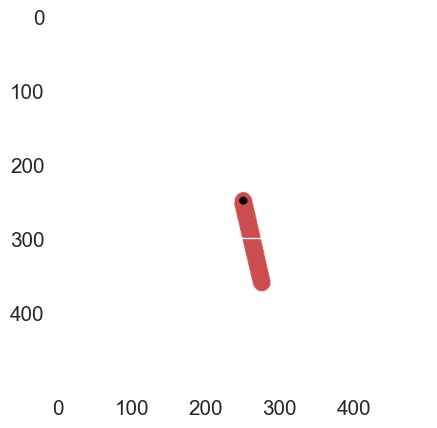

In [97]:
env, n_actions, _ = get_env('Pendulum-v1', False)

In [98]:
env.observation_space, env.action_space

(Box([-1. -1. -8.], [1. 1. 8.], (3,), float32), Box(-2.0, 2.0, (1,), float32))

Обучение агента:

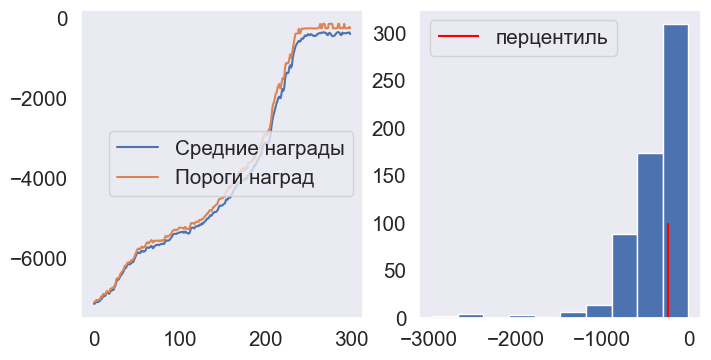

средняя награда = -383.172, порог=-237.960
CPU times: user 15min 29s, sys: 6min 17s, total: 21min 46s
Wall time: 22min 48s


In [176]:
%%time

params = {}
params['learning_rate_init'] = 0.001
agent, _  = train_agent(classification=False, epsilon=0.5, name='Pendulum-v1', n_train_steps=300,
                n_game_steps=1000, n_sessions=300, percentile=70, goal_score=-300, history_length=2,
                n_jobs=16, verbose=True, agent_mul_fac=2.5, **params)

Доучим

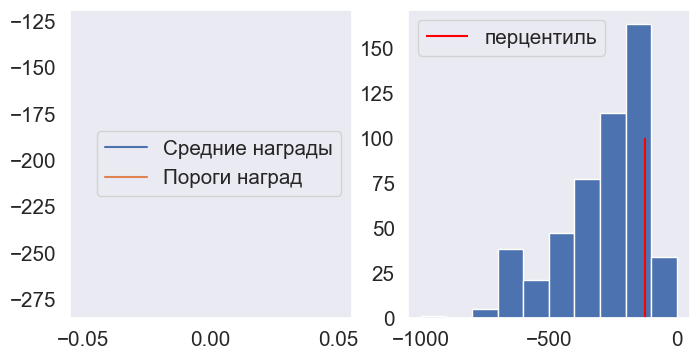

средняя награда = -277.468, порог=-126.403
Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
CPU times: user 6.39 s, sys: 9.15 s, total: 15.5 s
Wall time: 19.7 s


In [179]:
%%time

params = {}
params['learning_rate_init'] = 0.001
agent, _  = train_agent(agent=agent, classification=False, epsilon=0.5, name='Pendulum-v1', n_train_steps=100,
                n_game_steps=1000, n_sessions=500, percentile=70, goal_score=-300, history_length=2,
                n_jobs=16, verbose=True, agent_mul_fac=3.0, **params)

Детерминированная стратегия:

In [180]:
record_sessions(agent, "Pendulum_T", en='Pendulum-v1', classification=False, epsilon=.5, agent_mul_fac=2., test=True)

Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-0.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-1.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-2.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-3.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-4.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-5.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-6.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-7.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-8.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-9.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-10.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-11.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-12.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-13.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-14.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-15.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-15.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-16.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-16.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-17.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-17.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-18.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-18.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-19.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-19.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-20.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-21.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-21.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-22.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-22.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-23.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-23.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-24.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-24.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-25.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-25.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-26.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-26.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-27.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-28.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-28.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-29.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-29.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-30.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-30.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-31.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-31.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-32.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-32.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-33.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-33.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-34.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-34.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-35.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-35.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-36.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-36.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-37.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-37.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-38.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-38.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-39.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-39.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-40.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-41.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-41.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-42.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-42.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-43.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-43.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-44.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-44.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-45.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-45.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-46.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-46.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-47.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-47.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-48.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-48.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-49.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-49.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-50.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-50.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-51.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-51.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-52.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-52.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-53.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-53.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-54.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-54.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-55.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-55.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-56.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-56.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-57.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-57.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-58.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-58.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-59.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-59.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-60.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-61.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-61.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-62.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-62.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-63.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-63.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-64.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-65.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-65.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-66.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-66.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-67.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-67.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-68.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-68.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-69.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-69.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-70.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-70.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-71.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-71.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-72.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-72.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-73.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-73.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-74.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-74.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-75.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-75.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-76.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-76.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-77.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-77.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-78.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-78.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-79.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-79.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-80.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-81.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-81.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-82.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-82.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-83.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-83.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-84.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-84.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-85.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-85.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-86.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-86.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-87.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-87.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-88.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-88.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-89.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-89.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-90.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-90.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-91.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-91.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-92.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-92.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-93.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-93.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-94.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-94.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-95.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-95.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-96.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-96.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-97.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-97.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-98.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-98.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-99.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_T/rl-video-episode-99.mp4


In [181]:
video_paths = sorted([s for s in Path("videos", "Pendulum_T").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)
HTML("""
    <video width="640" height="480" controls>
    <source src="{}" type="video/mp4">
    </video>
    """.format(data_url)
    )

Стохастическая стратегия:

In [182]:
record_sessions(agent, "Pendulum_F", en='Pendulum-v1', classification=False, epsilon=.5, agent_mul_fac=2., test=False)

Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-0.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-1.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-2.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-3.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-4.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-5.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-6.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-7.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-8.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-9.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-10.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-11.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-12.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-13.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-14.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-15.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-15.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-16.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-16.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-17.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-17.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-18.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-18.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-19.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-19.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-20.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-21.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-21.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-22.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-22.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-23.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-23.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-24.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-24.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-25.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-25.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-26.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-26.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-27.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-28.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-28.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-29.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-29.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-30.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-30.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-31.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-31.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-32.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-32.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-33.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-33.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-34.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-34.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-35.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-35.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-36.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-36.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-37.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-37.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-38.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-38.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-39.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-39.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-40.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-41.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-41.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-42.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-42.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-43.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-43.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-44.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-44.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-45.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-45.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-46.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-46.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-47.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-47.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-48.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-48.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-49.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-49.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-50.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-50.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-51.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-51.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-52.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-52.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-53.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-53.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-54.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-54.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-55.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-55.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-56.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-56.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-57.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-57.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-58.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-58.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-59.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-59.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-60.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-61.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-61.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-62.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-62.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-63.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-63.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-64.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-65.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-65.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-66.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-66.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-67.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-67.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-68.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-68.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-69.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-69.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-70.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-70.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-71.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-71.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-72.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-72.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-73.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-73.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-74.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-74.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-75.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-75.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-76.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-76.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-77.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-77.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-78.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-78.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-79.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-79.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-80.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-81.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-81.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-82.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-82.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-83.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-83.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-84.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-84.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-85.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-85.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-86.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-86.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-87.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-87.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-88.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-88.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-89.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-89.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-90.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-90.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-91.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-91.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-92.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-92.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-93.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-93.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-94.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-94.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-95.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-95.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-96.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-96.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-97.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-97.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-98.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-98.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-99.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/Pendulum_F/rl-video-episode-99.mp4


In [183]:
video_paths = sorted([s for s in Path("videos", "Pendulum_F").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)
HTML("""
    <video width="640" height="480" controls>
    <source src="{}" type="video/mp4">
    </video>
    """.format(data_url)
    )

## Обучение MountainCarContinuous-v0

state vector dim = 2
n_actions = 1


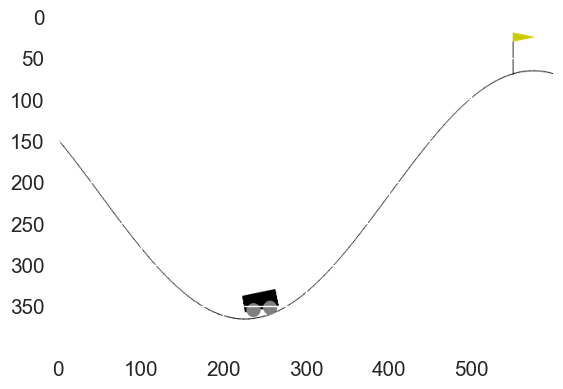

In [184]:
env, n_actions, _ = get_env('MountainCarContinuous-v0', False)

In [185]:
env.observation_space, env.action_space

(Box([-1.2  -0.07], [0.6  0.07], (2,), float32), Box(-1.0, 1.0, (1,), float32))

Обучение агента:

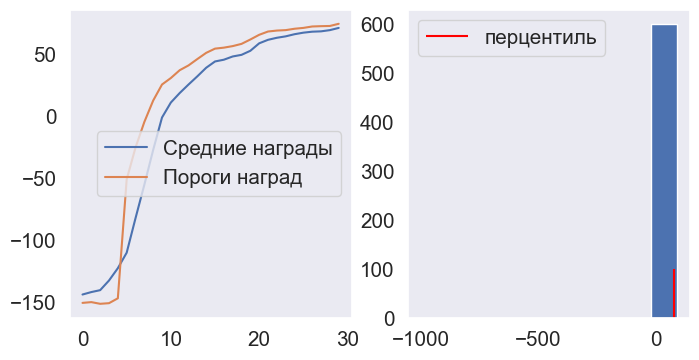

средняя награда = 70.966, порог=74.286
Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
CPU times: user 52.5 s, sys: 14.3 s, total: 1min 6s
Wall time: 57.4 s


In [194]:
%%time

params = {}
params['learning_rate_init'] = 0.001
agent, _  = train_agent(classification=False, epsilon=1.0, name='MountainCarContinuous-v0', n_train_steps=300,
                n_game_steps=1000, n_sessions=300, percentile=70, goal_score=70, history_length=2,
                n_jobs=16, verbose=True, agent_mul_fac=1.0, **params)

Детерминированная стратегия:

In [195]:
record_sessions(agent, "CarCont_T", en='MountainCarContinuous-v0', classification=False, epsilon=1.0, agent_mul_fac=1.0, test=True)

Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-0.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-1.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-2.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-3.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-4.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-5.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-6.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-7.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-8.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-9.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-10.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-11.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-12.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-13.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-14.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-15.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-15.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-16.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-16.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-17.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-17.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-18.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-18.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-19.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-19.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-20.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-21.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-21.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-22.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-22.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-23.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-23.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-24.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-24.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-25.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-25.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-26.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-26.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-27.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-28.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-28.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-29.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-29.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-30.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-30.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-31.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-31.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-32.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-32.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-33.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-33.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-34.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-34.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-35.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-35.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-36.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-36.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-37.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-37.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-38.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-38.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-39.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-39.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-40.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-41.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-41.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-42.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-42.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-43.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-43.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-44.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-44.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-45.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-45.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-46.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-46.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-47.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-47.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-48.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-48.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-49.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-49.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-50.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-50.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-51.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-51.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-52.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-52.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-53.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-53.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-54.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-54.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-55.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-55.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-56.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-56.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-57.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-57.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-58.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-58.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-59.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-59.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-60.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-61.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-61.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-62.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-62.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-63.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-63.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-64.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-65.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-65.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-66.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-66.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-67.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-67.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-68.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-68.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-69.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-69.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-70.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-70.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-71.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-71.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-72.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-72.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-73.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-73.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-74.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-74.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-75.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-75.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-76.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-76.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-77.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-77.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-78.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-78.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-79.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-79.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-80.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-81.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-81.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-82.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-82.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-83.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-83.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-84.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-84.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-85.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-85.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-86.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-86.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-87.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-87.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-88.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-88.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-89.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-89.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-90.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-90.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-91.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-91.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-92.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-92.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-93.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-93.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-94.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-94.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-95.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-95.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-96.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-96.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-97.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-97.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-98.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-98.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-99.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_T/rl-video-episode-99.mp4


In [196]:
video_paths = sorted([s for s in Path("videos", "CarCont_T").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)
HTML("""
    <video width="640" height="480" controls>
    <source src="{}" type="video/mp4">
    </video>
    """.format(data_url)
    )

Стохастическая стратегия:

In [197]:
record_sessions(agent, "CarCont_F", en='MountainCarContinuous-v0', classification=False, epsilon=1.0, agent_mul_fac=1.0, test=False)

Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-0.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-1.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-2.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-3.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-4.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-5.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-6.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-7.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-8.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-9.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-10.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-11.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-12.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-13.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-14.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-15.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-15.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-16.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-16.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-17.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-17.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-18.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-18.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-19.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-19.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-20.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-21.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-21.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-22.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-22.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-23.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-23.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-24.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-24.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-25.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-25.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-26.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-26.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-27.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-28.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-28.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-29.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-29.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-30.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-30.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-31.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-31.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-32.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-32.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-33.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-33.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-34.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-34.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-35.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-35.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-36.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-36.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-37.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-37.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-38.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-38.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-39.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-39.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-40.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-41.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-41.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-42.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-42.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-43.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-43.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-44.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-44.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-45.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-45.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-46.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-46.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-47.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-47.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-48.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-48.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-49.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-49.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-50.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-50.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-51.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-51.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-52.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-52.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-53.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-53.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-54.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-54.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-55.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-55.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-56.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-56.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-57.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-57.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-58.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-58.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-59.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-59.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-60.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-61.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-61.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-62.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-62.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-63.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-63.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-64.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-65.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-65.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-66.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-66.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-67.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-67.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-68.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-68.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-69.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-69.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-70.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-70.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-71.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-71.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-72.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-72.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-73.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-73.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-74.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-74.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-75.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-75.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-76.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-76.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-77.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-77.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-78.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-78.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-79.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-79.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-80.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-81.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-81.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-82.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-82.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-83.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-83.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-84.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-84.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-85.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-85.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-86.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-86.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-87.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-87.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-88.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-88.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-89.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-89.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-90.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-90.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-91.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-91.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-92.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-92.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-93.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-93.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-94.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-94.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-95.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-95.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-96.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-96.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-97.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-97.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-98.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-98.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-99.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/CarCont_F/rl-video-episode-99.mp4


In [198]:
video_paths = sorted([s for s in Path("videos", "CarCont_F").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)
HTML("""
    <video width="640" height="480" controls>
    <source src="{}" type="video/mp4">
    </video>
    """.format(data_url)
    )

## Обучение LunarLanderContinuous-v2

state vector dim = 8
n_actions = 2


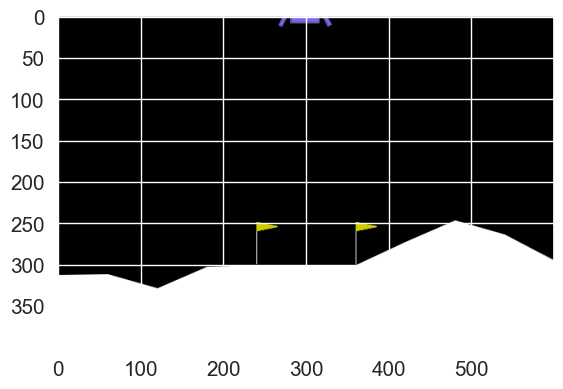

In [276]:
env, n_actions, _ = get_env('LunarLanderContinuous-v2', False)

In [277]:
env.observation_space, env.action_space

(Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
  -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
  1.       ], (8,), float32),
 Box(-1.0, 1.0, (2,), float32))

Обучение агента:

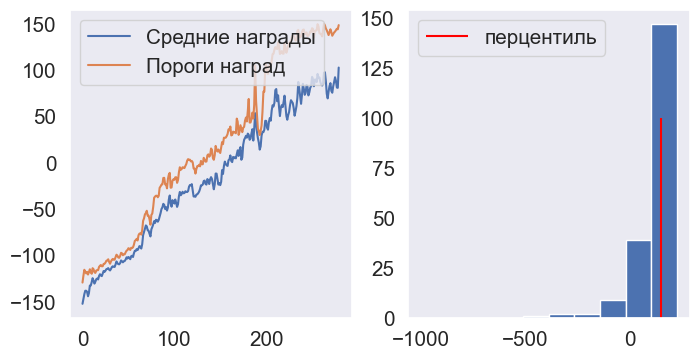

средняя награда = 102.833, порог=148.587
Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
CPU times: user 1h 27min 2s, sys: 1min 12s, total: 1h 28min 14s
Wall time: 1h 25min 25s


In [300]:
%%time

params = {}
params['learning_rate_init'] = 0.005
agent, _  = train_agent(classification=False, epsilon=1.0, name='LunarLanderContinuous-v2', n_train_steps=300,
                n_game_steps=1000, n_sessions=100, percentile=70, goal_score=100, history_length=2,
                n_jobs=1, verbose=True, agent_mul_fac=2.0, **params)

Детерминированная стратегия:

In [301]:
record_sessions(agent, "LunarCont_T", en='LunarLanderContinuous-v2', classification=False, epsilon=1.0, agent_mul_fac=2.0, test=True)

Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-0.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-1.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-2.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-3.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-4.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-5.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-6.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-7.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-8.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-9.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-10.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-11.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-12.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-13.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-14.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-15.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-15.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-16.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-16.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-17.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-17.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-18.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-18.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-19.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-19.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-20.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-21.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-21.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-22.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-22.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-23.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-23.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-24.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-24.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-25.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-25.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-26.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-26.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-27.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-28.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-28.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-29.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-29.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-30.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-30.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-31.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-31.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-32.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-32.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-33.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-33.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-34.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-34.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-35.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-35.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-36.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-36.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-37.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-37.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-38.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-38.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-39.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-39.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-40.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-41.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-41.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-42.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-42.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-43.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-43.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-44.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-44.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-45.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-45.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-46.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-46.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-47.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-47.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-48.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-48.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-49.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-49.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-50.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-50.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-51.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-51.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-52.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-52.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-53.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-53.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-54.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-54.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-55.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-55.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-56.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-56.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-57.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-57.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-58.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-58.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-59.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-59.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-60.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-61.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-61.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-62.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-62.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-63.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-63.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-64.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-65.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-65.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-66.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-66.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-67.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-67.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-68.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-68.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-69.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-69.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-70.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-70.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-71.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-71.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-72.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-72.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-73.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-73.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-74.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-74.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-75.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-75.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-76.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-76.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-77.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-77.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-78.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-78.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-79.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-79.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-80.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-81.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-81.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-82.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-82.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-83.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-83.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-84.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-84.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-85.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-85.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-86.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-86.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-87.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-87.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-88.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-88.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-89.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-89.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-90.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-90.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-91.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-91.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-92.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-92.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-93.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-93.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-94.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-94.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-95.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-95.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-96.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-96.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-97.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-97.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-98.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-98.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-99.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_T/rl-video-episode-99.mp4


In [302]:
video_paths = sorted([s for s in Path("videos", "LunarCont_T").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)
HTML("""
    <video width="640" height="480" controls>
    <source src="{}" type="video/mp4">
    </video>
    """.format(data_url)
    )

Стохастическая стратегия:

In [303]:
record_sessions(agent, "LunarCont_F", en='LunarLanderContinuous-v2', classification=False, epsilon=1.0, agent_mul_fac=2.0, test=False)

Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-0.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-1.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-2.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-3.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-4.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-5.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-6.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-7.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-8.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-9.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-10.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-11.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-12.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-13.mp4


Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-14.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-15.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-15.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-16.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-16.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-16.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-17.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-17.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-17.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-18.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-18.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-18.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-19.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-19.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-19.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-20.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-20.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-21.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-21.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-21.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-22.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-22.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-22.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-23.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-23.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-23.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-24.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-24.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-24.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-25.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-25.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-26.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-26.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-26.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-27.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-27.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-27.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-28.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-28.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-28.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-29.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-29.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-29.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-30.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-30.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-31.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-31.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-31.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-32.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-32.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-32.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-33.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-33.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-33.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-34.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-34.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-34.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-35.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-35.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-36.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-36.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-36.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-37.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-37.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-37.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-38.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-38.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-38.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-39.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-39.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-39.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-40.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-40.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-41.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-41.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-41.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-42.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-42.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-42.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-43.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-43.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-43.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-44.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-44.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-44.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-45.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-45.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-46.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-46.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-46.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-47.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-47.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-47.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-48.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-48.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-48.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-49.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-49.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-49.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-50.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-50.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-51.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-51.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-51.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-52.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-52.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-52.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-53.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-53.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-53.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-54.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-54.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-54.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-55.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-55.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-56.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-56.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-56.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-57.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-57.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-57.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-58.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-58.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-58.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-59.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-59.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-59.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-60.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-60.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-61.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-61.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-61.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-62.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-62.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-62.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-63.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-63.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-63.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-64.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-64.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-64.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-65.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-65.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-66.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-66.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-66.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-67.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-67.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-67.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-68.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-68.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-68.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-69.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-69.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-69.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-70.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-70.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-71.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-71.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-71.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-72.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-72.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-72.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-73.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-73.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-73.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-74.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-74.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-74.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-75.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-75.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-76.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-76.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-76.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-77.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-77.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-77.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-78.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-78.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-78.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-79.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-79.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-79.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-80.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-80.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-81.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-81.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-81.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-82.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-82.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-82.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-83.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-83.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-83.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-84.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-84.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-84.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-85.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-85.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-86.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-86.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-86.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-87.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-87.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-87.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-88.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-88.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-88.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-89.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-89.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-89.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-90.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-90.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-91.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-91.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-91.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-92.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-92.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-92.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-93.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-93.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-93.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-94.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-94.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-94.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-95.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-95.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-96.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-96.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-96.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-97.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-97.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-97.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-98.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-98.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-98.mp4
Moviepy - Building video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-99.mp4.
Moviepy - Writing video /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-99.mp4



Moviepy - Done !
Moviepy - video ready /Users/aleksandrbogdanov/Учеба/8 Семестр/RL/videos/LunarCont_F/rl-video-episode-99.mp4


In [304]:
video_paths = sorted([s for s in Path("videos", "LunarCont_F").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]
data_url = str(video_path)
HTML("""
    <video width="640" height="480" controls>
    <source src="{}" type="video/mp4">
    </video>
    """.format(data_url)
    )